In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np

from train_utils import *

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

## Fashion MNIST

In [3]:
global batch_size, test_batch_size, epochs, lr, gamma, no_cuda, dry_run, seed, log_interval, save_model, device

device = torch.device("cuda:0")
use_cuda = True
batch_size = 254
test_batch_size = 1000
epochs = 50
lr = 0.001
gamma = 0.2
no_cuda = False
dry_run = False
seed = 1
log_interval = 1000
save_model = True

In [4]:
import torchvision
import torchvision.transforms as transforms


## Load indexes

In [5]:
import numpy as np

scores = np.load('values.npy')

In [6]:
from torch.utils.data import Dataset, DataLoader


class FashionDataset(Dataset):    
    def __init__(self, data, scores_data=None, indices=None, transform = transforms.Compose([transforms.ToTensor()])):
        self.fashion_MNIST = data.values
        self.transform = transform
        self.scores_data = scores_data
        
        label = []
        image = []
        
        for i in self.fashion_MNIST:
            label.append(i[0])
            image.append(i[1:])
        self.targets = np.asarray(label)
        # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')
        self.indices = (
            indices if indices is not None else np.arange(len(self.images))
        )

    def __getitem__(self, index):
        
        index = self.indices[index]
            
        label = self.targets[index]
        image = self.images[index]
        image = self.transform(image)
        
        if self.scores_data is not None:
            return image, label, self.scores_data[index]
        return image, label

    def __len__(self):
        return len(self.indices)



In [7]:
import pandas as pd

trainset = pd.read_csv("fashion-mnist_train.csv")
testset = pd.read_csv("fashion-mnist_test.csv")

test_dataset = FashionDataset(testset)
test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

In [9]:
def train_with_special_idx(trainset, test_loader, scores, idx):
    indexData = FashionDataset(trainset, scores, idx)
    idx_train_loader = torch.utils.data.DataLoader(indexData,**train_kwargs)
    
    teacher = FashionCNN()
    teacher.load_state_dict(torch.load(f'teacher_fashion_mnist.pt'))
    teacher.to(device)
    freeze_model(teacher)
    
    model = FashionCNN()
    model.load_state_dict(torch.load(f'fashionCNN.pt'))
    model.to(device)
    return train_with_teacher(student, teacher, idx_train_loader, test_loader)

In [10]:
aver_random_acc_list = []
aver_max_ind_ch_T_acc_list = []
aver_random_ind_ch_T_acc_list = []
aver_max_ind_const_T_acc_list = []
aver_random_ind_const_T_acc_list = []

In [11]:
bs_list = [100, 200, 1000, 2000, 3000, 4000, 5000]

num_repeat = 10
global IS_CONST_T
for bs in bs_list:
    print(bs)
    random_acc_list = []
    max_ind_ch_T_acc_list = []
    random_ind_ch_T_acc_list = []
    max_ind_const_T_acc_list = []
    random_ind_const_T_acc_list = []
    for _ in range(num_repeat):
        
        max_indexes = scores.argsort()[-bs:][::-1]
        random_indexes = np.random.choice(scores.argsort(), size=bs, replace=False)
    
        IS_CONST_T = True
        max_idx_loss_const_T, max_idx_acc_const_T = train_with_special_idx(trainset, test_loader, scores, max_indexes)
        random_idx_loss_const_T, random_idx_acc_const_T = train_with_special_idx(trainset, test_loader, scores, random_indexes)
        
    
        IS_CONST_T = False
        random_idx_loss, random_idx_acc = train_with_special_idx(trainset, test_loader, scores, random_indexes)
        max_idx_loss, max_idx_acc = train_with_special_idx(trainset, test_loader, scores, max_indexes)    
    
        
        
        max_ind_ch_T_acc_list.append(max_idx_acc[-1])
        random_ind_ch_T_acc_list.append(random_idx_acc[-1])
        max_ind_const_T_acc_list.append(max_idx_acc_const_T[-1])
        random_ind_const_T_acc_list.append(random_idx_acc_const_T[-1])
        
    aver_max_ind_ch_T_acc_list.append(np.mean(max_ind_ch_T_acc_list))
    aver_random_ind_ch_T_acc_list.append(np.mean(random_ind_ch_T_acc_list))
    aver_max_ind_const_T_acc_list.append(np.mean(max_ind_const_T_acc_list))
    aver_random_ind_const_T_acc_list.append(np.mean(random_ind_const_T_acc_list))
    

100


RuntimeError: CUDA error: out of memory

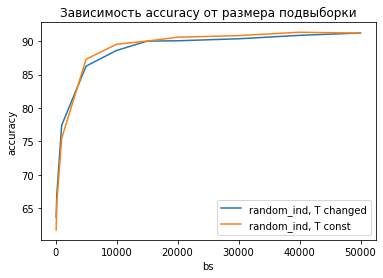

In [41]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(bs_list, aver_random_ind_ch_T_acc_list, label = 'random_ind, T changed')
plt.plot(bs_list, aver_random_ind_const_T_acc_list, label = 'random_ind, T const')


plt.title(f'Зависимость accuracy от размера подвыборки')
plt.xlabel('bs')
plt.ylabel('accuracy')

plt.legend(loc = 'lower right')
plt.show()

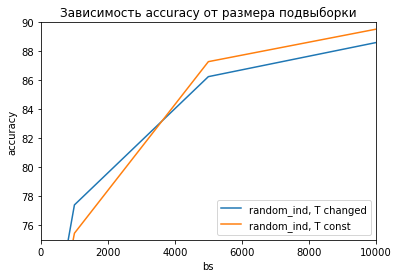

In [44]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(bs_list, aver_random_ind_ch_T_acc_list, label = 'random_ind, T changed')
plt.plot(bs_list, aver_random_ind_const_T_acc_list, label = 'random_ind, T const')


plt.title(f'Зависимость accuracy от размера подвыборки')
plt.xlabel('bs')
plt.ylabel('accuracy')
plt.ylim([75, 90])
plt.xlim([0, 10000])
plt.legend(loc = 'lower right')
plt.show()

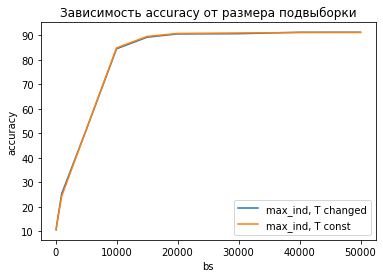

In [45]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(bs_list, aver_max_ind_ch_T_acc_list, label = 'max_ind, T changed')
plt.plot(bs_list, aver_max_ind_const_T_acc_list, label = 'max_ind, T const')


plt.title(f'Зависимость accuracy от размера подвыборки')
plt.xlabel('bs')
plt.ylabel('accuracy')

plt.legend(loc = 'lower right')
plt.show()

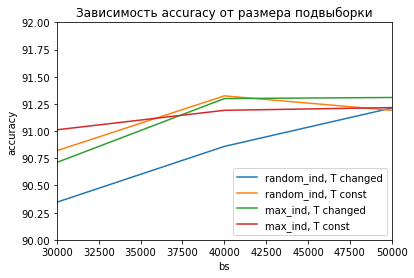

In [40]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(bs_list, aver_random_ind_ch_T_acc_list, label = 'random_ind, T changed')
plt.plot(bs_list, aver_random_ind_const_T_acc_list, label = 'random_ind, T const')
plt.plot(bs_list, aver_max_ind_ch_T_acc_list, label = 'max_ind, T changed')
plt.plot(bs_list, aver_max_ind_const_T_acc_list, label = 'max_ind, T const')


plt.title(f'Зависимость accuracy от размера подвыборки')
plt.xlabel('bs')
plt.ylabel('accuracy')
plt.legend(loc = 'lower right')
plt.show()